# 4. Reconstruction from features

Authors: Léonard Seydoux and René Steinmann

Date: March 7, 2023

After retrieving the most relevant features with an ICA from the scattering coefficients, we can now check what these features are actually telling us. So far, they seem abstract and have no physical unit. However, we can understand better the features, if we look on how they are constructed and how they would reconstruct its input, the scattering coefficients. This strategy was mainly discussed in this [paper](https://doi.org/10.1029/2022GL098854), where we can track the superficial freezing and thawing process on a single indepedent component.

In [12]:
import numpy as np
import pickle
import os
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from scipy.signal import medfilt


## Paths

Please, ensure that you have read and write permission in the following path. Also make sure that the path is located outside the repository, or that is is correctly ignored in the `.gitignore` file, to prevent from pushing it or erasing it when pulling from the main branch.

In [10]:
SAVE_PATH = "example/"


## Load the data
For this notebook we need to load the scattering network model, the dimensionality reduction model and the independent components.

In [21]:
# Load the scattering network
filepath = os.path.join(SAVE_PATH, "scattering_network.pickle")
network = pickle.load(open(filepath, "rb"))

# Load the dimensionality reduction model
filepath = os.path.join(SAVE_PATH, "dimension_model.pickle")
dimension_model = pickle.load(open(filepath, "rb"))

# load data from file
filepath = os.path.join(SAVE_PATH, "independent_components.npz")
with np.load(filepath) as data:
    features = data["features"]
    times = data["times"]


## Extracting the unmixing matrix from the FastICA model

FastICA finds a set of independent components $\mathbf{s}$ by multiplying an unmixing matrix $\mathbf{W}$ to the scattering coefficients stored in the matrix $\mathbf{x}$: 

$\mathbf{s} = \mathbf{W} \mathbf{x}$

The FastICA model stores the unmixing matrix $\mathbf{W}$ in the attribute `components_` (more information on [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA)). We can extract the weights of the unmixing matrix and visualize it to understand better what each indepedent component 'means', since it connects the scattering coefficients to the independent components.
To give an example on how to use the information of the unmixing matrix, we will choose one single independent component and extract the unmixing weights for that component.

(15546.0, 15547.999768518519)

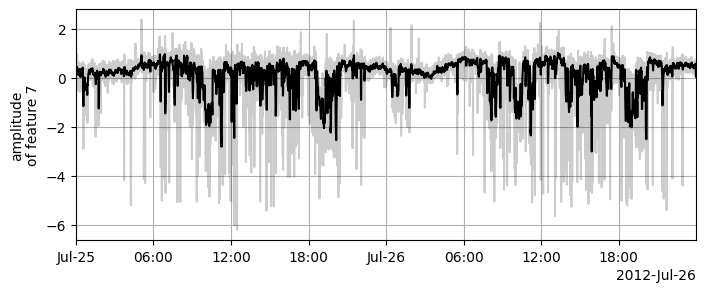

In [34]:
# choosing one feature to show the weights
iFeature = 7
weights_comp = dimension_model.components_[iFeature]

fig, ax = plt.subplots(1, figsize=(8, 3))
ax.plot(times, medfilt(features[:, iFeature], kernel_size=21), color="k")
ax.plot(times, features[:, iFeature], color="k", alpha=0.2)
ax.grid(which="both")
ax.set_ylabel("amplitude\nof feature %s" % (iFeature))

# Date labels
dateticks = mdates.AutoDateLocator()
datelabels = mdates.ConciseDateFormatter(dateticks)
ax.xaxis.set_major_locator(dateticks)
ax.xaxis.set_major_formatter(datelabels)
ax.set_xlim(times.min(), times.max())


In [35]:
# information from the scattering network, important for showing the weights later according to the frequency of the wavelets
size_layer_0 = network.banks[0].octaves * network.banks[0].resolution
size_layer_1 = network.banks[1].octaves * network.banks[1].resolution
f_layer_0 = network.banks[0].centers
f_layer_1 = network.banks[1].centers

# the weights are applied to the vectorized scattering coefficients,
# here we reshape the weights for the 2nd-order scattering coefficients to assign f_layer_0 and f_layer_1 later
ic_2ndLayer_e = np.reshape(
    weights_comp[3 * size_layer_0 : 3 * size_layer_0 + size_layer_0 * size_layer_1],
    (size_layer_0, size_layer_1),
)
ic_2ndLayer_n = np.reshape(
    weights_comp[
        3 * size_layer_0
        + size_layer_0 * size_layer_1 : 3 * size_layer_0
        + size_layer_0 * size_layer_1 * 2
    ],
    (size_layer_0, size_layer_1),
)
ic_2ndLayer_z = np.reshape(
    weights_comp[3 * size_layer_0 + size_layer_0 * size_layer_1 * 2 :],
    (size_layer_0, size_layer_1),
)

ic_2ndLayer = np.array([ic_2ndLayer_e, ic_2ndLayer_n, ic_2ndLayer_z])


/tmp/ipykernel_5468/3289940530.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


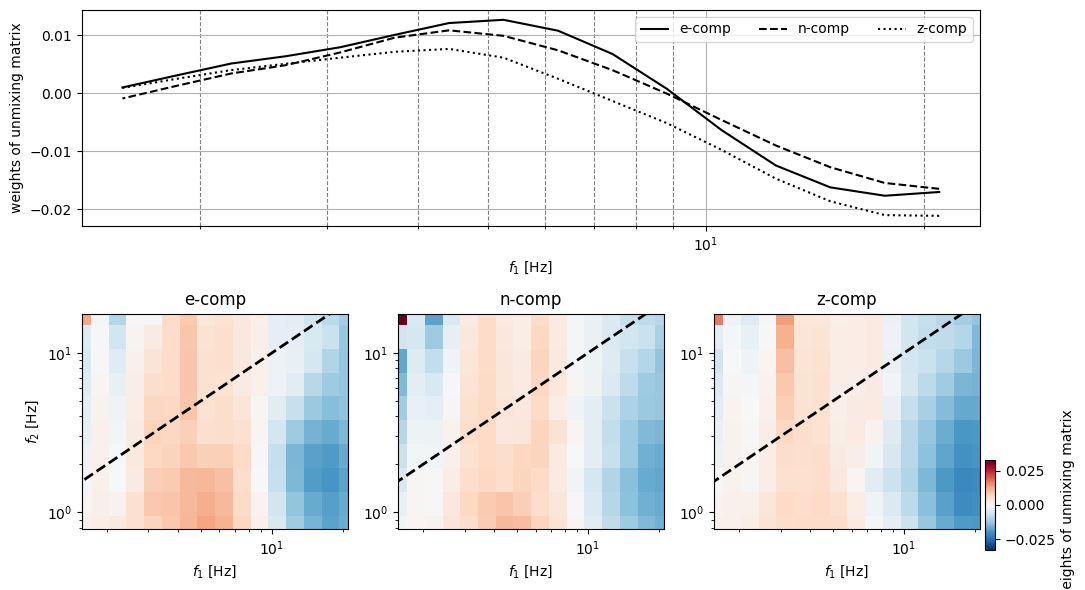

In [37]:
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 3, figure=fig)

ax2 = fig.add_subplot(gs[0, :])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1], sharex=ax3, sharey=ax3)
ax5 = fig.add_subplot(gs[1, 2], sharex=ax3, sharey=ax3)


ax2.plot(f_layer_0, weights_comp[:size_layer_0], "-k", label="e-comp")
ax2.plot(
    f_layer_0, weights_comp[size_layer_0 : 2 * size_layer_0], "--k", label="n-comp"
)
ax2.plot(
    f_layer_0, weights_comp[2 * size_layer_0 : 3 * size_layer_0], ":k", label="z-comp"
)
ax2.set_xlabel("$f_1$ [Hz]")
ax2.set_ylabel("weights of unmixing matrix")
ax2.grid()
ax2.grid(axis="x", which="minor", color="grey", linestyle="--")
ax2.set_xscale("log")
ax2.legend(ncol=3)

vmin = -np.max(np.abs(weights_comp))
vmax = np.max(np.abs(weights_comp))
ax3.set_title("e-comp")
ax3.pcolormesh(
    f_layer_0,
    f_layer_1,
    ic_2ndLayer_e.T,
    vmin=vmin,
    vmax=vmax,
    cmap="RdBu_r",
    rasterized=True,
    shading="auto",
)
ax3.set_yscale("log")
ax3.set_xscale("log")

ax4.set_title("n-comp")
ax4.pcolormesh(
    f_layer_0,
    f_layer_1,
    ic_2ndLayer_n.T,
    vmin=vmin,
    vmax=vmax,
    cmap="RdBu_r",
    rasterized=True,
    shading="auto",
)
ax4.set_yscale("log")
ax4.set_xscale("log")

ax5.set_title("z-comp")
im = ax5.pcolormesh(
    f_layer_0,
    f_layer_1,
    ic_2ndLayer_z.T,
    vmin=vmin,
    vmax=vmax,
    cmap="RdBu_r",
    rasterized=True,
    shading="auto",
)
ax5.set_yscale("log")
ax5.set_xscale("log")
ax3.set_xlabel("$f_1$ [Hz]")
ax4.set_xlabel("$f_1$ [Hz]")
ax5.set_xlabel("$f_1$ [Hz]")
ax3.set_ylabel("$f_2$ [Hz]")
ax3.set_xlim(np.min(f_layer_0), np.max(f_layer_0))
ax3.set_ylim(np.min(f_layer_1), np.max(f_layer_1))

for single_ax in [ax3, ax4, ax5]:
    single_ax.plot(np.linspace(0.1, 100, 4), np.linspace(0.1, 100, 4), "--k", lw=2)

fig.subplots_adjust(right=0.97)
cbar_ax = fig.add_axes([0.99, 0.075, 0.01, 0.15])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("weights of unmixing matrix")

fig.tight_layout()
plt.show()


In [24]:
def show_reconstruction(iFeature=0):
    features, times, ica_model, network = load_data()

    size_layer_0 = network.banks[0].octaves * network.banks[0].resolution
    size_layer_1 = network.banks[1].octaves * network.banks[1].resolution
    f_layer_0 = network.banks[0].centers
    f_layer_1 = network.banks[1].centers

    Y_filt = np.zeros(features.shape)
    Y_filt[:, iFeature] = features[:, iFeature]
    sc_filt = ica_model.inverse_transform(Y_filt)

    fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)

    vmin_spec = sc_filt[:, : 3 * size_layer_0].min()
    vmax_spec = sc_filt[:, : 3 * size_layer_0].max()

    ax[0].pcolormesh(
        times,
        f_layer_0,
        sc_filt[:, :size_layer_0].T,
        vmin=vmin_spec,
        vmax=vmax_spec,
        rasterized=True,
    )
    ax[1].pcolormesh(
        times,
        f_layer_0,
        sc_filt[:, size_layer_0 : 2 * size_layer_0].T,
        vmin=vmin_spec,
        vmax=vmax_spec,
        rasterized=True,
    )
    ax[2].pcolormesh(
        times,
        f_layer_0,
        sc_filt[:, 2 * size_layer_0 : 3 * size_layer_0].T,
        vmin=vmin_spec,
        vmax=vmax_spec,
        rasterized=True,
    )
    ax[0].set_ylabel("$f_0 [Hz]$")
    ax[1].set_ylabel("$f_0 [Hz]$")
    ax[2].set_ylabel("$f_0 [Hz]$")
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    ax[2].xaxis.set_minor_locator(mdates.MonthLocator())
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))
    ax[2].xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax[2].set_yscale("log")
    plt.show()

    pass


In [4]:
show_weights_feature()


FileNotFoundError: [Errno 2] No such file or directory: 'example/indepedent_components.npz'

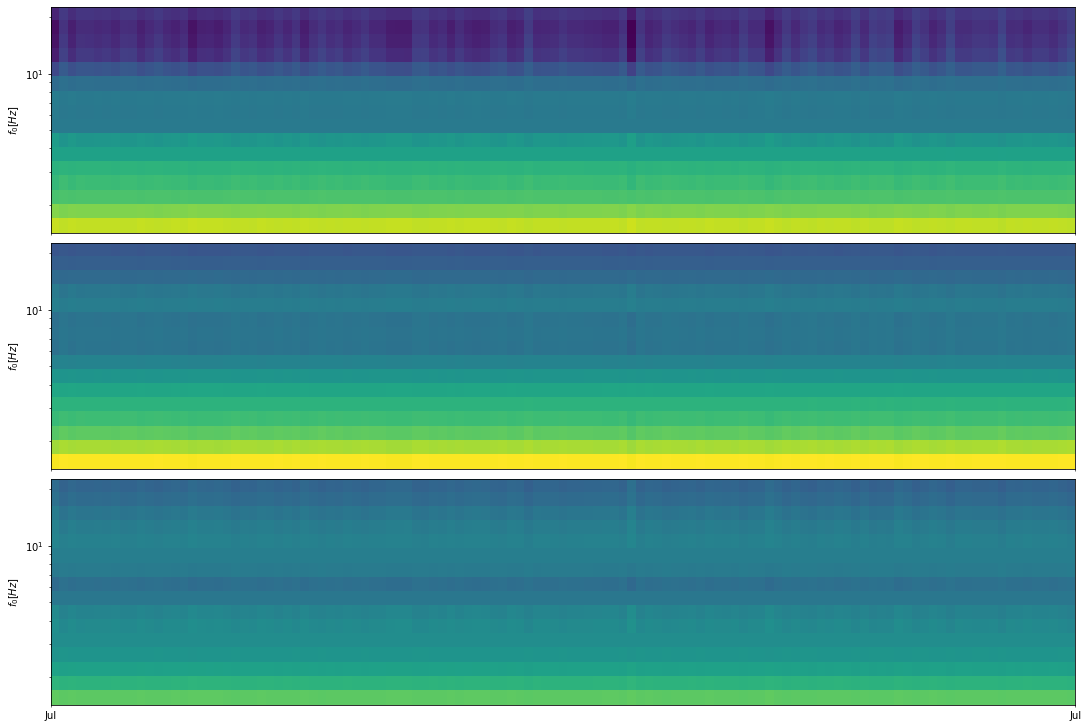

In [ ]:
show_reconstruction()
